In [73]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, roc_auc_score, mean_absolute_error
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE

In [74]:
# Load historical dataset (1950-2024)
data_path = '/content/drive/MyDrive/F1/'
races = pd.read_csv(data_path + 'races.csv')
results = pd.read_csv(data_path + 'results.csv')
drivers = pd.read_csv(data_path + 'drivers.csv')
constructors = pd.read_csv(data_path + 'constructors.csv')
qualifying = pd.read_csv(data_path + 'qualifying.csv')
lap_times = pd.read_csv(data_path + 'lap_times.csv')
pit_stops = pd.read_csv(data_path + 'pit_stops.csv')

print(races.shape)
print(results.shape)
print(drivers.shape)
print(constructors.shape)
print(qualifying.shape)
print(lap_times.shape)
print(pit_stops.shape)


(1125, 18)
(26759, 18)
(861, 9)
(212, 5)
(10494, 9)
(589081, 6)
(11371, 7)


In [75]:
print(races.head())
print(results.head())
print(drivers.head())
print(constructors.head())
print(qualifying.head())
print(lap_times.head())
print(pit_stops.head())

   raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   
2       3  2009      3         17     Chinese Grand Prix  2009-04-19   
3       4  2009      4          3     Bahrain Grand Prix  2009-04-26   
4       5  2009      5          4     Spanish Grand Prix  2009-05-10   

       time                                                url fp1_date  \
0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
1  09:00:00  http://en.wikipedia.org/wiki/2009_Malaysian_Gr...       \N   
2  07:00:00  http://en.wikipedia.org/wiki/2009_Chinese_Gran...       \N   
3  12:00:00  http://en.wikipedia.org/wiki/2009_Bahrain_Gran...       \N   
4  12:00:00  http://en.wikipedia.org/wiki/2009_Spanish_Gran...       \N   

  fp1_time fp2_date fp2_time fp3_date fp3_time quali_date quali_time  \
0       \N       \N       \N       \N       

In [76]:
# Filter for Japanese Grand Prix (Suzuka, circuitId = 22)
japan_races = races[races['circuitId'] == 22]
japan_results = results[results['raceId'].isin(japan_races['raceId'])]
data = japan_results.merge(drivers, on='driverId').merge(constructors, left_on='constructorId', right_on='constructorId').merge(races, on='raceId').merge(qualifying, on=['raceId', 'driverId'], how='left')


In [77]:
# Prepare target
data['positionOrder'] = pd.to_numeric(data['positionOrder'], errors='coerce')
data['winner'] = (data['positionOrder'] == 1).astype(int)
data = data.dropna(subset=['positionOrder'])

# Feature Engineering

In [78]:
# Feature Engineering
data = data.sort_values(['driverId', 'year', 'raceId'])

# Driver form
data['driver_form'] = data.groupby('driverId')['positionOrder'].shift(1).rolling(5, min_periods=1).mean()

# Constructor form
data['constructor_form'] = data.groupby('constructorId_x')['points'].shift(1).rolling(5, min_periods=1).mean()

In [79]:
# Suzuka-specific performance
suzuka_data = data[data['circuitId'] == 22].copy()
suzuka_driver_avg = suzuka_data.groupby('driverId')['positionOrder'].rolling(5, min_periods=1).mean().reset_index()
suzuka_driver_avg = suzuka_driver_avg.rename(columns={'positionOrder': 'suzuka_driver_avg_y'}) # Rename to a unique name
suzuka_driver_avg['raceId'] = suzuka_data['raceId'].values
suzuka_driver_avg['driverId'] = suzuka_data['driverId'].values
# Specify suffixes to avoid conflicts
data = data.merge(suzuka_driver_avg[['raceId', 'driverId', 'suzuka_driver_avg_y']], on=['raceId', 'driverId'], how='left', suffixes=('_x', '_y'))

# print(data.head())


In [80]:
# Driver age
data['dob'] = pd.to_datetime(data['dob'])
data['date'] = pd.to_datetime(data['date'])
data['driver_age'] = (data['date'] - data['dob']).dt.days / 365.25

print(data.head())

   resultId  raceId  driverId  constructorId_x number_x  grid position_x  \
0      7836      15         1                1        1     3          3   
1     20687     352         1                1        2     8          5   
2     21116     855         1                1        3     3          5   
3     21572     874         1                1        4     9          5   
4     22039     895         1              131       10     3         \N   

  positionText  positionOrder  points  ...  number position_y        q1  \
0            3              3     6.0  ...     1.0        3.0  1:30.917   
1            5              5    10.0  ...     2.0        3.0  1:32.809   
2            5              5    10.0  ...     3.0        3.0  1:32.843   
3            5              5    10.0  ...     4.0        9.0  1:33.061   
4            R             20     0.0  ...    10.0        3.0  1:32.340   

         q2        q3 winner driver_form  constructor_form  \
0  1:30.627  1:32.395      0  

In [81]:
# Qualifying time difference
def time_to_seconds(time_str):
    if pd.isna(time_str) or time_str == '':
        return np.nan
    try:
        minutes, seconds = time_str.split(':')
        return float(minutes) * 60 + float(seconds)
    except:
        return np.nan

data['q3_seconds'] = data['q3'].apply(time_to_seconds)
data['fastest_q3'] = data.groupby('raceId')['q3_seconds'].transform('min')
data['q3_diff'] = data['q3_seconds'] - data['fastest_q3']
data['qualifying_pace'] = data.groupby('raceId')['q3_seconds'].rank()



In [82]:
# Pole position indicator
data['is_pole'] = (data['grid'] == 1).astype(int)

In [83]:
# Suzuka races (experience)
suzuka_races_per_driver = suzuka_data.groupby('driverId').size().reset_index(name='suzuka_races')
data = data.merge(suzuka_races_per_driver, on='driverId', how='left')
data['suzuka_races'] = data['suzuka_races'].fillna(0)

In [84]:
# Recent form (average position in 2024 races) - Fixed MergeError
# Drop 'year' column from results if it exists to avoid duplicates
if 'year' in results.columns:
    results = results.drop(columns=['year'])

# Merge results with races to add 'year' column
results = results.merge(races[['raceId', 'year']], on='raceId', how='left')

# Now calculate recent_form_2024
recent_form_2024 = results[results['year'] == 2024].groupby('driverId')['positionOrder'].mean().reset_index(name='recent_form_2024')

# Drop existing 'recent_form_2024' columns to avoid conflicts
data = data.drop(columns=['recent_form_2024', 'recent_form_2024_x'], errors='ignore')

# Merge the new recent_form_2024 data
data = data.merge(recent_form_2024, on='driverId', how='left')
data['recent_form_2024'] = data['recent_form_2024'].fillna(20)

In [85]:
# Fastest lap potential (average rank of fastest lap in past Suzuka races)
suzuka_lap_times = lap_times[lap_times['raceId'].isin(japan_races['raceId'])]
fastest_lap_rank = suzuka_lap_times.groupby(['raceId', 'driverId'])['time'].min().reset_index()
fastest_lap_rank['rank'] = fastest_lap_rank.groupby('raceId')['time'].rank()
avg_fastest_lap_rank = fastest_lap_rank.groupby('driverId')['rank'].mean().reset_index(name='fastest_lap_rank')
data = data.merge(avg_fastest_lap_rank, on='driverId', how='left')
data['fastest_lap_rank'] = data['fastest_lap_rank'].fillna(20)

In [86]:
# Tyre strategy (average number of pit stops in past Suzuka races)
suzuka_pit_stops = pit_stops[pit_stops['raceId'].isin(japan_races['raceId'])]
avg_pit_stops = suzuka_pit_stops.groupby(['raceId', 'driverId']).size().reset_index(name='num_stops')
avg_pit_stops = avg_pit_stops.groupby('driverId')['num_stops'].mean().reset_index(name='avg_pit_stops')
data = data.merge(avg_pit_stops, on='driverId', how='left')
data['avg_pit_stops'] = data['avg_pit_stops'].fillna(2)

# Weather impact (historical races, simplified)

In [88]:
# Assume some historical races had rain; set to 0 for 2025 prediction (dry forecast)
data['is_rain'] = 0

# Train Model with XGBoost and LightGBM Ensemble
# Use 'suzuka_driver_avg_y' instead of 'suzuka_driver_avg'
features = ['grid', 'driver_form', 'constructor_form', 'suzuka_driver_avg_y', 'qualifying_pace', 'driver_age', 'q3_diff', 'is_pole', 'suzuka_races', 'recent_form_2024', 'fastest_lap_rank', 'avg_pit_stops', 'is_rain']
X = data[features].fillna(0)
y = data['winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [89]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [90]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

# Model Build and Train

In [91]:
# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Define LightGBM model
lgbm_model = LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42
)

In [92]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_search_xgb.fit(X_train_resampled, y_train_resampled)

# Best XGBoost model
best_xgb_model = grid_search_xgb.best_estimator_
print("Best XGBoost Parameters:", grid_search_xgb.best_params_)

Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [93]:
# Hyperparameter tuning for LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=param_grid_lgbm, cv=5, scoring='f1', n_jobs=-1)
grid_search_lgbm.fit(X_train_resampled, y_train_resampled)

# Best LightGBM model
best_lgbm_model = grid_search_lgbm.best_estimator_
print("Best LightGBM Parameters:", grid_search_lgbm.best_params_)

[LightGBM] [Info] Number of positive: 603, number of negative: 603
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1792
[LightGBM] [Info] Number of data points in the train set: 1206, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [94]:
# Ensemble with XGBoost and LightGBM
ensemble_model = VotingClassifier(estimators=[
    ('xgb', best_xgb_model),
    ('lgbm', best_lgbm_model)
], voting='soft')

In [95]:
# Train ensemble model
ensemble_model.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 603, number of negative: 603
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1792
[LightGBM] [Info] Number of data points in the train set: 1206, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             max_depth=7, n_estimators=200,
                                             objective='binary',
                                             random_state=42, subsample=0.8))],
                 voting='soft')

In [96]:
# Evaluate with cross-validation
cv_scores = cross_val_score(ensemble_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", cv_scores.mean())

[LightGBM] [Info] Number of positive: 27, number of negative: 605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [97]:
# Evaluate on test set
y_pred = ensemble_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9748427672955975
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       154
           1       0.67      0.40      0.50         5

    accuracy                           0.97       159
   macro avg       0.82      0.70      0.74       159
weighted avg       0.97      0.97      0.97       159



# Loss Calculation

In [98]:
# Log Loss
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1] # get predicted probabilities
log_loss_value = log_loss(y_test, y_pred_proba)
print("Log Loss:", log_loss_value)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

# Mean Absolute Error for Probabilities
mae_proba = mean_absolute_error(y_test, y_pred_proba)
print("Mean Absolute Error (Probabilities):", mae_proba)

Log Loss: 0.1922239828476408
ROC-AUC Score: 0.8428571428571429
Mean Absolute Error (Probabilities): 0.040701808800985985


# Prediction

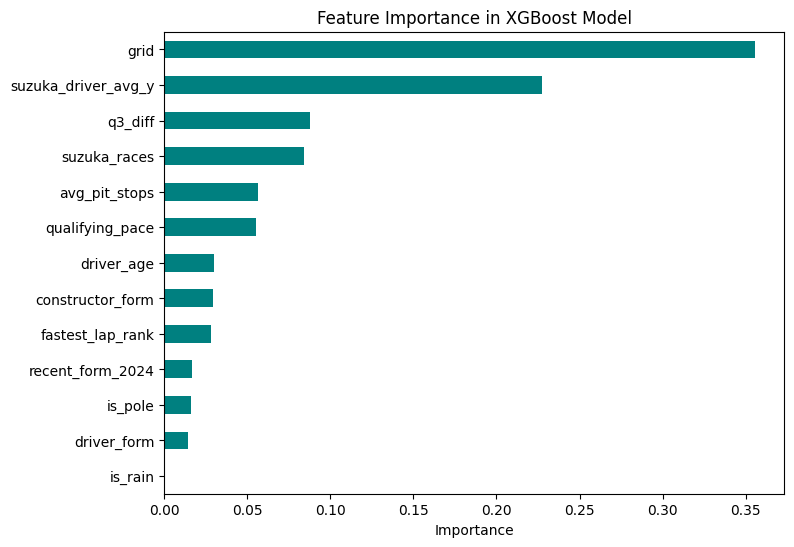

In [99]:
# Feature Importance (using XGBoost as reference)
importance = pd.Series(best_xgb_model.feature_importances_, index=features)
plt.figure(figsize=(8, 6))
importance.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance in XGBoost Model')
plt.xlabel('Importance')
plt.show()

In [104]:
# Predict 2025 Japanese Grand Prix
# next_race = pd.DataFrame({
#     'grid': [1, 2, 3, 4, 5, 6, 7],
#     'driver_form': [1.5, 2.0, 3.0, 3.5, 4.0, 5.0, 6.0],
#     'constructor_form': [18.0, 22.5, 22.5, 15.0, 12.0, 14.0, 14.0],
#     'suzuka_driver_avg': [1.5, 4.0, 5.0, 4.5, 5.5, 3.0, 6.0],
#     'qualifying_pace': [1, 2, 3, 4, 5, 6, 7],
#     'driver_age': [27.5, 25.4, 24.0, 27.5, 30.6, 40.2, 27.1],
#     'q3_diff': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
#     'is_pole': [1, 0, 0, 0, 0, 0, 0],
#     'suzuka_races': [5, 4, 3, 6, 7, 15, 5],
#     'recent_form_2024': [1.2, 2.5, 4.0, 3.0, 4.5, 5.0, 6.0],
#     'fastest_lap_rank': [1.5, 3.0, 4.0, 2.5, 5.0, 3.5, 6.0],
#     'avg_pit_stops': [2.0, 2.5, 2.5, 2.0, 2.0, 2.0, 2.0],
#     'is_rain': [0, 0, 0, 0, 0, 0, 0]
# })

# Predict 2025 Japanese Grand Prix
next_race = pd.DataFrame({
    'grid': list(range(1, 21)),
    'driver_form': [1.5, 5.0, 2.0, 3.0, 3.5, 5.0, 6.0, 7.0, 4.0, 8.0, 6.5, 9.0, 7.5, 8.5, 6.0, 10.0, 9.0, 11.0, 10.5, 7.0],
    'constructor_form': [18.0, 18.0, 22.5, 22.5, 15.0, 15.0, 14.0, 14.0, 12.0, 12.0, 10.0, 10.0, 11.0, 11.0, 9.0, 9.0, 8.0, 8.0, 7.0, 7.0],
    'suzuka_driver_avg_y': [1.5, 6.0, 4.0, 5.0, 4.5, 3.0, 6.0, 7.0, 5.5, 8.0, 6.5, 9.0, 7.0, 8.5, 6.0, 10.0, 9.0, 11.0, 10.0, 7.5],
    'qualifying_pace': list(range(1, 21)),
    'driver_age': [27.5, 24.0, 25.4, 24.0, 27.5, 40.2, 27.1, 19.0, 43.0, 26.0, 29.0, 23.0, 27.0, 22.0, 24.0, 21.0, 31.0, 22.0, 19.0, 27.0],
    'q3_diff': [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8],
    'is_pole': [1] + [0] * 19,
    'suzuka_races': [5, 2, 4, 3, 6, 15, 5, 1, 12, 5, 6, 2, 5, 2, 4, 1, 6, 1, 1, 5],
    'recent_form_2024': [1.2, 6.0, 2.5, 4.0, 3.0, 5.0, 6.0, 8.0, 4.5, 7.0, 6.5, 9.0, 7.5, 8.5, 6.0, 10.0, 9.0, 11.0, 10.5, 7.0],
    'fastest_lap_rank': [1.5, 5.0, 3.0, 4.0, 2.5, 3.5, 6.0, 8.0, 5.5, 7.0, 6.5, 9.0, 7.5, 8.5, 6.0, 10.0, 9.0, 11.0, 10.0, 7.0],
    'avg_pit_stops': [2.0, 2.0, 2.5, 2.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],
    'is_rain': [0] * 20
})

In [101]:
# Driver names for reference
# Updated driver list for 2025
# drivers = ['Lewis Hamilton', 'Lando Norris', 'Charles Leclerc', 'Oscar Piastri', 'Max Verstappen', 'George Russell', 'Liam Lawson']

# Driver names for reference
drivers = [
    'Max Verstappen', 'Liam Lawson',  # Red Bull
    'Lando Norris', 'Oscar Piastri',  # McLaren
    'Charles Leclerc', 'Lewis Hamilton',  # Ferrari
    'George Russell', 'Kimi Antonelli',  # Mercedes
    'Fernando Alonso', 'Lance Stroll',  # Aston Martin
    'Pierre Gasly', 'Jack Doohan',  # Alpine
    'Alex Albon', 'Franco Colapinto',  # Williams
    'Yuki Tsunoda', 'Isack Hadjar',  # RB
    'Nico Hulkenberg', 'Theo Pourchaire',  # Sauber
    'Oliver Bearman', 'Esteban Ocon'  # Haas
]

In [105]:
# Predict probabilities
probabilities = ensemble_model.predict_proba(next_race)[:, 1]

# Create prediction DataFrame
prediction_df = pd.DataFrame({
    'Driver': drivers,
    'Win Probability': probabilities
})

# Sort by win probability
prediction_df = prediction_df.sort_values(by='Win Probability', ascending=False)

In [106]:
# Display predicted winner and podium
print("Predicted Winner and Podium for 2025 Japanese Grand Prix:")
print(f"Winner: {prediction_df.iloc[0]['Driver']} (Probability: {prediction_df.iloc[0]['Win Probability']:.2f})")
print("Podium:")
for i in range(3):
    print(f"{i+1}. {prediction_df.iloc[i]['Driver']} (Probability: {prediction_df.iloc[i]['Win Probability']:.2f})")

Predicted Winner and Podium for 2025 Japanese Grand Prix:
Winner: Max Verstappen (Probability: 1.00)
Podium:
1. Max Verstappen (Probability: 1.00)
2. Lando Norris (Probability: 0.03)
3. George Russell (Probability: 0.03)
